# Prepare Google Colab Environment

In [1]:
!git clone https://github.com/mhamilton723/STEGO.git

Cloning into 'STEGO'...
remote: Enumerating objects: 204, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 204 (delta 27), reused 21 (delta 21), pack-reused 166
Receiving objects: 100% (204/204), 9.23 MiB | 6.03 MiB/s, done.
Resolving deltas: 100% (104/104), done.


In [2]:
!pip install wget
!pip install torchmetrics
!pip install hydra-core
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git
!pip install omegaconf
!pip install pytorch-lightning

You should consider upgrading via the '/home/thu/anaconda3/envs/sg2/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/thu/anaconda3/envs/sg2/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/thu/anaconda3/envs/sg2/bin/python -m pip install --upgrade pip' command.
  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-ctfzshlo
  Running command git clone -q https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-ctfzshlo
  Resolved https://github.com/lucasb-eyer/pydensecrf.git to commit 0d53acbcf5123d4c88040fe68fbb9805fc5b2fb9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pydensecrf: filename=pydensecrf-1.0rc2-cp39-cp39-linux_x86_64.whl size=267266 sha256=522f76729fb3ab3421538e7ba31551bef1ec6b005313c2f9ff2288e3f2c035ae
  Stored in directory: /tmp/pip-ephem-wheel-cache-

# Download Pretrained Model



In [3]:
import os
from os.path import join
os.chdir("STEGO/src")
saved_models_dir = join("..", "saved_models")
os.makedirs(saved_models_dir, exist_ok=True)

In [4]:
import wget
saved_model_url_root = "https://marhamilresearch4.blob.core.windows.net/stego-public/saved_models/"
saved_model_name = "cocostuff27_vit_base_5.ckpt"
if not os.path.exists(join(saved_models_dir, saved_model_name)):
  wget.download(saved_model_url_root + saved_model_name, join(saved_models_dir, saved_model_name))

# Load pretrained STEGO

In [5]:
from train_segmentation import LitUnsupervisedSegmenter

model = LitUnsupervisedSegmenter.load_from_checkpoint(join(saved_models_dir, saved_model_name)).cuda()

/home/thu/anaconda3/envs/sg2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/thu/lab/self-guidance/side_repo/STEGO/src/STEGO/src/train_segmentation.py:386: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path="configs", config_name="train_config.yml")


Since no pretrained weights have been provided, we load the reference pretrained DINO weights.


# Load Image

In [6]:
from PIL import Image
import requests
from io import BytesIO
from torchvision.transforms.functional import to_tensor
from utils import get_transform

img_url ="https://marhamilresearch4.blob.core.windows.net/stego-public/sample_images/moto1.jpg"
response = requests.get(img_url)
img = Image.open(BytesIO(response.content))
transform = get_transform(448, False, "center")
img = transform(img).unsqueeze(0).cuda()

/home/thu/anaconda3/envs/sg2/lib/python3.9/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


# Query model and pass result through CRF

In [7]:
import torch.nn.functional as F
from crf import dense_crf
import torch

with torch.no_grad():
  code1 = model(img)
  code2 = model(img.flip(dims=[3]))
  code  = (code1 + code2.flip(dims=[3])) / 2
  code = F.interpolate(code, img.shape[-2:], mode='bilinear', align_corners=False)
  linear_probs = torch.log_softmax(model.linear_probe(code), dim=1).cpu()
  cluster_probs = model.cluster_probe(code, 2, log_probs=True).cpu()

  single_img = img[0].cpu()
  linear_pred = dense_crf(single_img, linear_probs[0]).argmax(0)
  cluster_pred = dense_crf(single_img, cluster_probs[0]).argmax(0)

# Visualize Result

Note that cluster predictions will not be matched with ground truth classes in this example. For hungarian matching please use: `eval_segmentation.py`

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


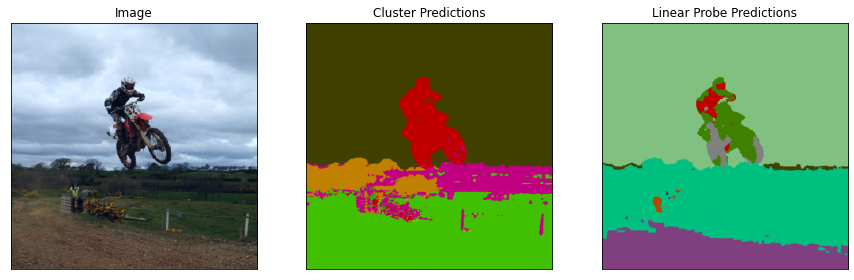

: 

In [8]:
import matplotlib.pyplot as plt
from utils import unnorm, remove_axes
fig, ax = plt.subplots(1,3, figsize=(5*3,5))
ax[0].imshow(unnorm(img)[0].permute(1,2,0).cpu())
ax[0].set_title("Image")
ax[1].imshow(model.label_cmap[cluster_pred])
ax[1].set_title("Cluster Predictions")
ax[2].imshow(model.label_cmap[linear_pred])
ax[2].set_title("Linear Probe Predictions")
remove_axes(ax)